In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

print(f'Train Shape: {df_train.shape}')
print(f'Test Shape: {df_test.shape}')

Train Shape: (1306122, 3)
Test Shape: (375806, 2)


In [3]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
df_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [5]:
df_train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

**Target Distribution in train set:**

In [6]:
df_train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [7]:
np.mean(df_train['target'].values)

0.06187017751787352

Only 6% of the total questions are insincere.
Conclusion: Dataset is higly skwed

In [8]:
#Bar graph for showing count of each target
count = df_train['target'].value_counts()

plot = go.Bar(x=count.index,y=count.values,marker=dict(color=count.values,colorscale = 'Picnic'))
layout = go.Layout(title = 'Target Value Count')

fig = go.Figure(data = [plot],layout=layout)
py.iplot(fig,filename='Value Count')

#Pie Chart for showing distribution

labels = count.index
value = np.array((count/count.sum())*100)

plot = go.Pie(labels=labels,values = value)
layout = go.Layout(title='Target Value Distribution')
fig = go.Figure(data=[plot],layout=layout)
py.iplot(fig,filename='Target Distribution')

In [9]:
#Wordcloud Representation
#Thanks for the Kernel: https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
from wordcloud import STOPWORDS,WordCloud

def wcloud(text,title=None,figure_size=(24.0,16.0)):
    stopwords = set(STOPWORDS)
    stopwords = stopwords.union({'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'})
    
    wordcloud = WordCloud(stopwords=stopwords,random_state = 42,width=800, 
                    height=400,).generate(str(text))
    
    plt.figure(figsize=figure_size)
    plt.title(title,fontdict={'size': 40,})
    plt.imshow(wordcloud)

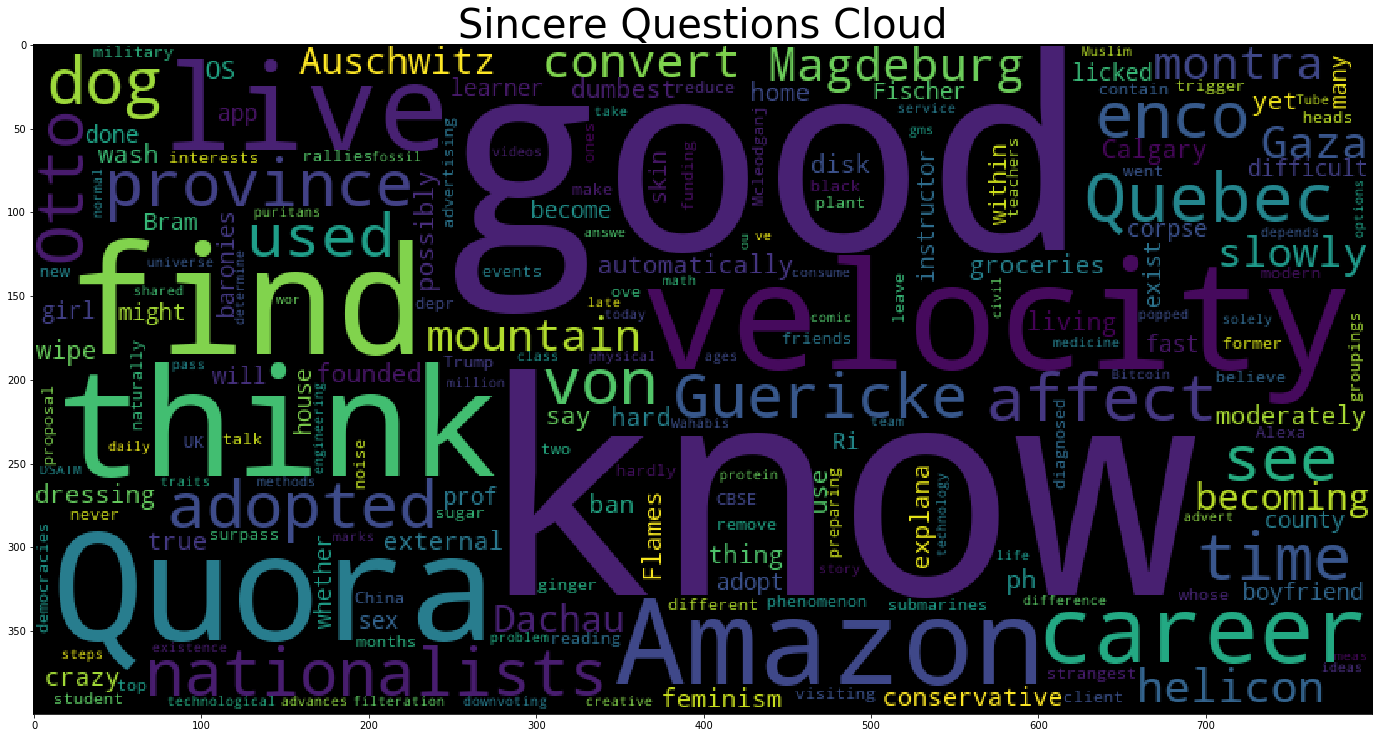

In [10]:
wcloud(df_train[df_train['target']==0]['question_text'],'Sincere Questions Cloud')

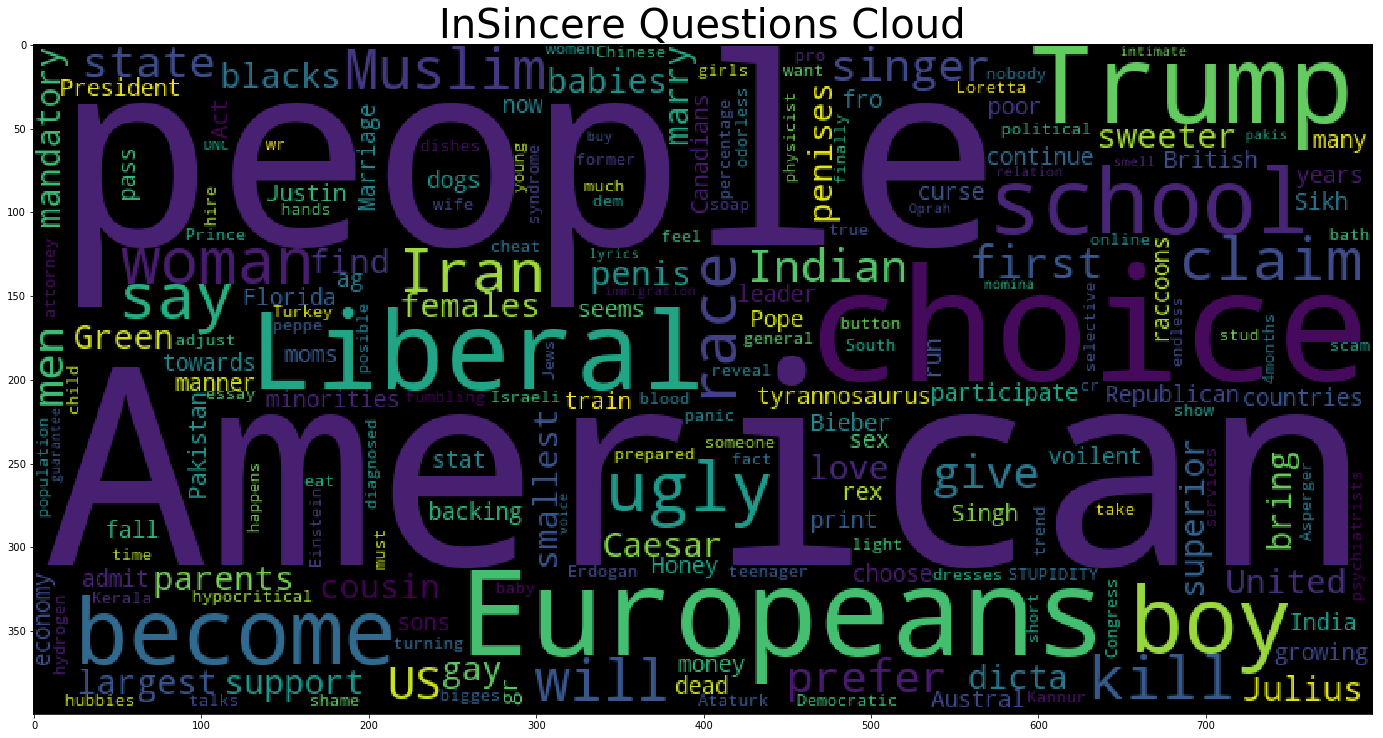

In [11]:
wcloud(df_train[df_train['target']==1]['question_text'],'InSincere Questions Cloud')

A variety of wodrs are present in both of the classes, let compare the ngrams for each of them

In [12]:
# Thanks SRK for the great kernel: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

from collections import defaultdict
train1_df = df_train[df_train["target"]==1]
train0_df = df_train[df_train["target"]==0]

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def generate_bar(df,color):
    plot = go.Bar(x=df['word_count'].values[::-1],y=df['word'].values[::-1],
                 orientation = 'h',showlegend=False,marker=dict(color=color))
    return plot

In [13]:
#Bar for insincere questions
freq_dict = defaultdict(int)
for que in train1_df['question_text']:
    for word in generate_ngrams(que,2):
        freq_dict[word]+=1
sorted_freq = pd.DataFrame(sorted(freq_dict.items(),key= lambda x:x[1])[::-1])
sorted_freq.columns = ['word', 'word_count']
plot1 = generate_bar(sorted_freq.head(50),'red')

In [14]:
#Bar for sincere questions
freq_dict = defaultdict(int)
for que in train0_df['question_text']:
    for word in generate_ngrams(que,2):
        freq_dict[word]+=1
sorted_freq = pd.DataFrame(sorted(freq_dict.items(),key= lambda x:x[1])[::-1])
sorted_freq.columns = ['word', 'word_count']
plot0 = generate_bar(sorted_freq.head(50),'blue')

In [15]:
# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(plot0, 1, 1)
fig.append_trace(plot1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



Plot clearly shows the set of words in Sincere and Insincere questions on quora

It's time to create some meta features and check out how they are distributed in the dataset:

* Number of words in the text
* Number of unique words in the text
* Number of characters in the text
* Number of stopwords
* Number of punctuations
* Number of upper case words
* Number of title case words
* Average length of the words

In [16]:
#Number of words#
df_train['word_count'] =  df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] =  df_test['question_text'].apply(lambda x: len(str(x).split()))

#Number of unique words
df_train['unique'] =  df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['unique'] =  df_test['question_text'].apply(lambda x: len(set(str(x).split())))

#Number of characters
df_train['char_count'] =  df_train['question_text'].apply(lambda x: len(str(x)))
df_test['char_count'] =  df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['stopwords'] =  df_train['question_text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))
df_test['stopwords'] =  df_test['question_text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))

#Number of Puncuations
df_train['punct'] =  df_train['question_text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
df_test['punct'] =  df_test['question_text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

#Number of UpperCase
df_train['upper'] =  df_train['question_text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
df_test['upper'] =  df_test['question_text'].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))

#Number of Title Case
df_train['title'] =  df_train['question_text'].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
df_test['title'] =  df_test['question_text'].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))

#Average length of word
#Number of characters
df_train['word_len'] =  df_train['question_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df_test['word_len'] =  df_test['question_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

In [17]:
df_train.head()

,qid,question_text,target,word_count,unique,char_count,stopwords,punct,upper,title,word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,10,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,7,1,2,3,4.200000


Let's divide tha values in different classes and then plot these values and to make things more interpretable

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



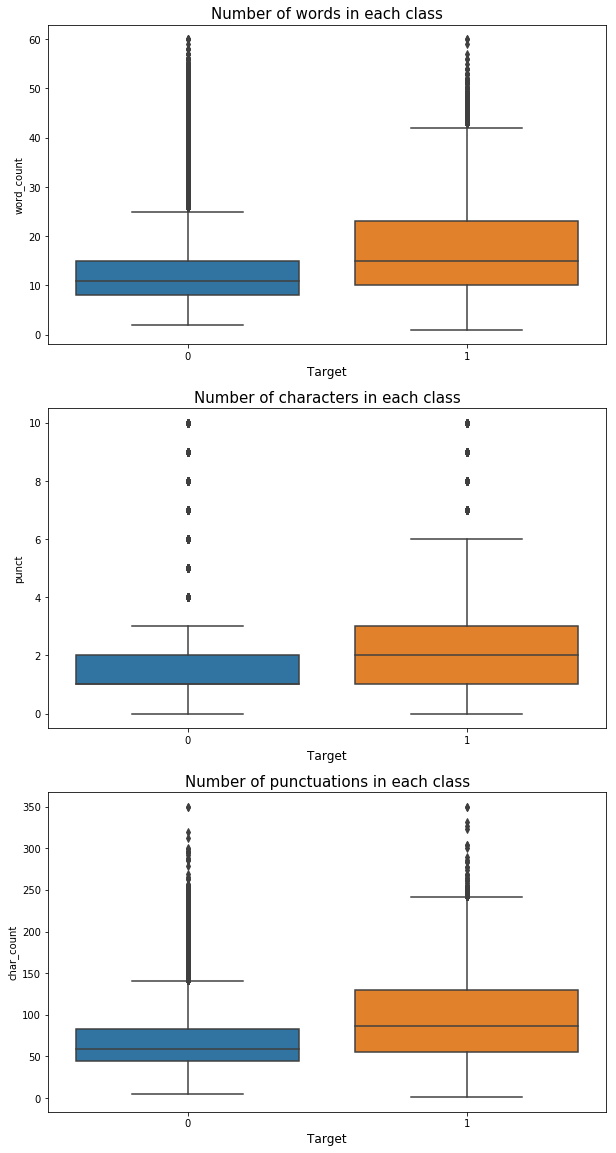

In [18]:
## Truncate some extreme values for better visuals ##
df_train['word_count'].loc[df_train['word_count']>60] = 60 #truncation for better visuals
df_train['punct'].loc[df_train['punct']>10] = 10 #truncation for better visuals
df_train['char_count'].loc[df_train['char_count']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='word_count', data=df_train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='punct', data=df_train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='char_count', data=df_train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

Conclusion:

It can be seen from the plots that insincere questions have more number of words, characters as well as punctuations from sincere questions, these features might be useful for our model.

Let's see how model performs by using these extra created features

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report, log_loss,f1_score

In [20]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)
eng_features = ['word_count','unique','char_count','stopwords','punct','upper','title','word_len']
cv_scores = []
pred_val = np.zeros([df_train.shape[0]])
for train_index, val_index in kf.split(df_train):
    X_train, X_val = df_train.loc[train_index][eng_features].values,df_train.loc[val_index][eng_features].values
    y_train, y_val = df_train.loc[train_index]['target'].values,df_train.loc[val_index]['target'].values
    classifier = LogisticRegression(class_weight='balanced',n_jobs = -1, solver='lbfgs')
    classifier.fit(X_train,y_train)
    pred = classifier.predict_proba(X_val)[:,1]
    pred_val[val_index] = pred
    cv_scores.append(log_loss(y_val,pred))
    

In [29]:
for thresh in np.arange(0.66, 0.67, 0.001):
    print(f"f1-score for threshold:{thresh} is {f1_score(y_val,pred>thresh)}")

f1-score for threshold:0.66 is 0.2541799647501548
f1-score for threshold:0.661 is 0.25387485648679675
f1-score for threshold:0.662 is 0.2535962152686055
f1-score for threshold:0.663 is 0.25379070944724347
f1-score for threshold:0.664 is 0.25380759824693094
f1-score for threshold:0.665 is 0.2539620807000486
f1-score for threshold:0.666 is 0.25393104795390176
f1-score for threshold:0.667 is 0.2537346383103981
f1-score for threshold:0.668 is 0.2535405531883451
f1-score for threshold:0.669 is 0.25395569620253167
f1-score for threshold:0.67 is 0.25377208655945993


In [30]:
print(accuracy_score(y_val,pred>0.66))

0.8801258689860043


We can see a classifiers created using only these features performs poorly on the dataset

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tf_idf = TfidfVectorizer(stop_words='english',ngram_range=(1,3))

tf_idf.fit(df_train['question_text'].values.tolist() + df_test['question_text'].values.tolist())

tf_train = tf_idf.transform(df_train['question_text'].values.tolist())
tf_test = tf_idf.transform(df_test['question_text'].values.tolist())

In [38]:
tf_train

<1306122x10689586 sparse matrix of type '<class 'numpy.float64'>'
	with 19501467 stored elements in Compressed Sparse Row format>

In [41]:
from sklearn.svm import LinearSVC

train_y = df_train["target"].values
cv_scores = []
pred_train = np.zeros([df_train.shape[0]])

svc = LinearSVC(random_state = 42)
kf = KFold(n_splits=5,shuffle=True,random_state=42)

for train_index, val_index in kf.split(df_train):
    X_train, X_val = tf_train[train_index], tf_train[val_index]
    y_train, y_val = train_y[train_index],train_y[val_index]
    svc.fit(X_train,y_train)
    pred = svc.predict(X_val)
    pred_train[val_index] = pred
    cv_scores.append(log_loss(y_val,pred))

In [42]:
cv_scores

[1.6844702061672496,
 1.7080050248406373,
 1.728240987862089,
 1.7078798065139975,
 1.7455623596271646]

In [44]:
for thresh in np.arange(0.1,0.8,0.1):
    print(f"f1-score for threshold:{thresh} is {f1_score(y_val,pred>thresh)}")
    

f1-score for threshold:0.1 is 0.4511972065181244
f1-score for threshold:0.2 is 0.4511972065181244
f1-score for threshold:0.30000000000000004 is 0.4511972065181244
f1-score for threshold:0.4 is 0.4511972065181244
f1-score for threshold:0.5 is 0.4511972065181244
f1-score for threshold:0.6 is 0.4511972065181244
f1-score for threshold:0.7000000000000001 is 0.4511972065181244


Using tf-idf boosts the scores significantly, performance can improved further by differnt model and changing the hyperparameters.

In [45]:
sub = pd.read_csv('../input/sample_submission.csv')

sub.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [47]:
df_test['prediction'] = svc.predict(tf_test)

In [52]:
df_sub = df_test.drop(labels=['question_text','word_count','word_count','unique',\
                              'char_count','stopwords','punct','upper','title','word_len'],axis = 1)
df_sub.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [54]:
df_sub.to_csv(path_or_buf='submission.csv',index=False)